# Interacting with CLIP

This is a self-contained notebook that shows how to download and run CLIP models, calculate the similarity between arbitrary image and text inputs, and perform zero-shot image classifications.

# Preparation for Colab

Make sure you're running a GPU runtime; if not, select "GPU" as the hardware accelerator in Runtime > Change Runtime Type in the menu. The next cells will install the `clip` package and its dependencies, and check if PyTorch 1.7.1 or later is installed.

In [ ]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 1.6 MB/s eta 0:00:00
  Attempting uninstall: wcwidth
    Found existing installation: wcwidth 0.2.10
    Uninstalling wcwidth-0.2.10:
      Successfully uninstalled wcwidth-0.2.10


  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-498mo6b_
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-498mo6b_
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369500 sha256=5a9e025188dbbd8707752d343e0c622051a27027ea8d31451a06ed3e94f5e54f
  Stored in directory: /tmp/pip-ephem-wheel-cache-q4kzwzul/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


# Loading the model

`clip.available_models()` will list the names of available CLIP models.

In [ ]:
import clip
import numpy as np

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [ ]:
model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

100%|███████████████████████████████████████| 338M/338M [00:04<00:00, 79.7MiB/s]


Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


# Image Preprocessing

We resize the input images and center-crop them to conform with the image resolution that the model expects. Before doing so, we will normalize the pixel intensity using the dataset mean and standard deviation.

The second return value from `clip.load()` contains a torchvision `Transform` that performs this preprocessing.



In [ ]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=warn)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x78901b179480>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

# Text Preprocessing

We use a case-insensitive tokenizer, which can be invoked using `clip.tokenize()`. By default, the outputs are padded to become 77 tokens long, which is what the CLIP models expects.

In [ ]:
clip.tokenize("Hello World!")

tensor([[49406,  3306,  1002,   256, 49407,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

# Setting up input images and texts

We are going to feed 8 example natrural/medical images and their textual descriptions to the model, and compare the similarity between the corresponding features.

The tokenizer is case-insensitive, and we can freely give any suitable textual descriptions.

In [ ]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from collections import OrderedDict
import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


# to mount google drive
if os.getcwd()=='/content':
    try:
        from google.colab import drive
        base_working_dir = '/content/drive/MyDrive'
        drive.mount('/content/drive')
    except:
        base_working_dir = os.getcwd()
        pass
!mkdir -p drive
!google-drive-ocamlfuse drive
print(base_working_dir)

Mounted at /content/drive
/bin/bash: line 1: google-drive-ocamlfuse: command not found
/content/drive/MyDrive


In [ ]:
# images to use and their textual descriptions
descriptions = {
    "page": "a page of text about segmentation",
    "chelsea": "a facial photo of a tabby cat",
    "astronaut": "a portrait of an astronaut with the American flag",
    "rocket": "a rocket standing on a launchpad",
    "motorcycle_right": "a red motorcycle standing in a garage",
    "camera": "a person looking at a camera on a tripod",
    "horse": "a black-and-white silhouette of a horse",
    "coffee": "a cup of coffee on a saucer"
}

med_descriptions = {
    "ROCO_00002": "CT scan in axial view showing obliteration of the left maxillary sinus",
    "ROCO_00017": "Coronary angiogram demonstrating occluded arteries",
    "ROCO_00028": "T2 weighted MRI image showing foraminal extensions of the cysts",
    "ROCO_00033": "Lytic lesions (arrows) involving the humerus.",
    "ROCO_00050": "Free air beneath the diaphragm at abdominal x-ray film",
    "ROCO_00056": "View of giant cell tumor of thumb metacarpal preoperatively",
    "ROCO_00060": "Transverse view of lung using CT.Leukemic infiltration is seen.",
    "ROCO_00135": "CT scan showing multiple non-communicating cysts in liver and kidney"
}

med_descriptions_2 = {
    "ROCO_81793": "CT scan of chest showing mediastinal mass and pathological fracture of the right 8th rib.",
    "ROCO_00202": "Plain abdominal X-ray after 3 days",
    "ROCO_31541": "Mycobacterium tuberculosis. High-resolution computed tomography shows a tree-in-bud appearance",
    "ROCO_72732": "MRI brain T2 image demonstrating a symmetric hyperintense lesion in the central pons.",
    "ROCO_43427": "Panoramic rx shows the presence of possible septa in the left maxilla.",
    "ROCO_81817": "Doppler ultrasound revealed extensive thrombosis involving the iliac veins",
    "ROCO_81797": "Axial view of CT chest revealing extensive pneumomediastinum and subcutaneous emphysema.",
    "ROCO_81807": "A burst fracture of L1 associated with a vertebral hemangioma causing canal compression with expansion of the L1 body.",
}

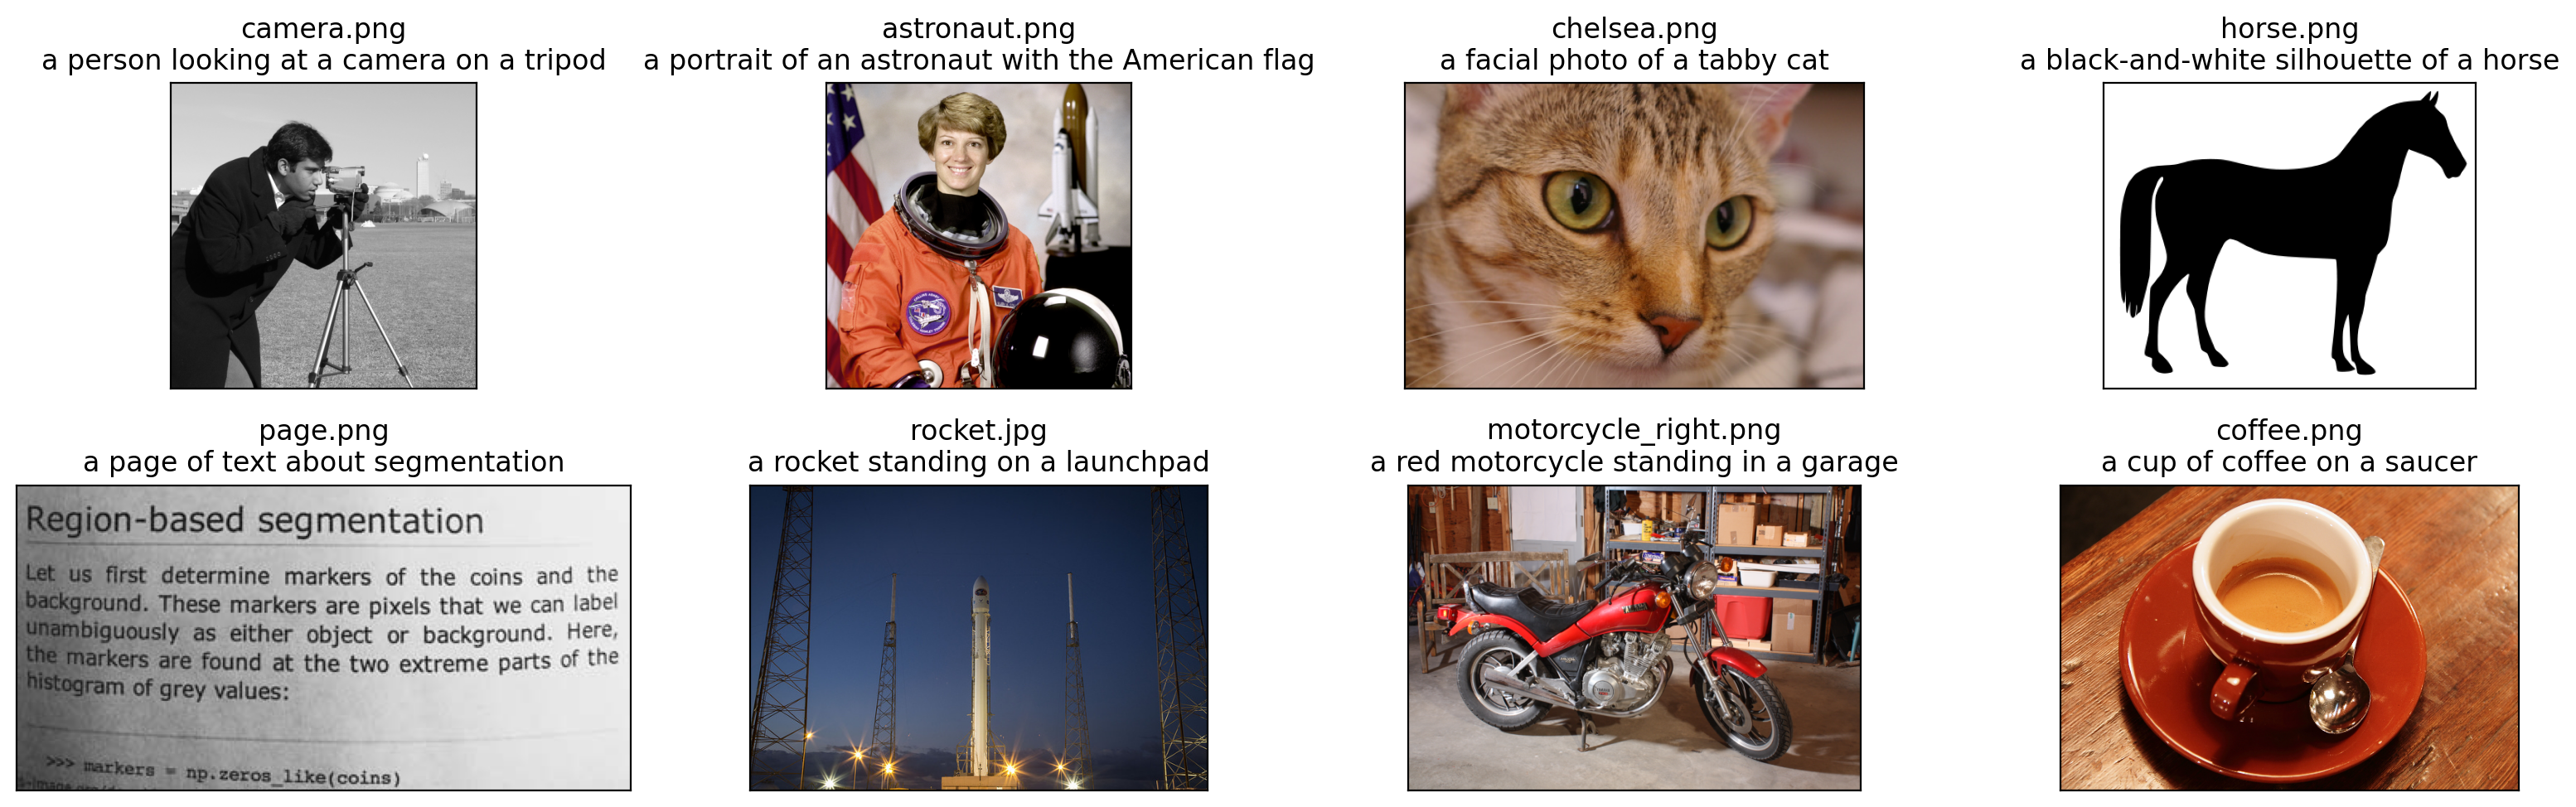

In [ ]:
original_images = []
images = []
texts = []
plt.figure(figsize=(16, 5))

for filename in [filename for filename in os.listdir(skimage.data_dir) if filename.endswith(".png") or filename.endswith(".jpg")]:
    name = os.path.splitext(filename)[0]
    if name not in descriptions:
        continue

    image = Image.open(os.path.join(skimage.data_dir, filename)).convert("RGB")

    plt.subplot(2, 4, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{filename}\n{descriptions[name]}")
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    images.append(preprocess(image))
    texts.append(descriptions[name])

plt.tight_layout()


## Building features

We normalize the images, tokenize each text input, and run the forward pass of the model to get the image and text features.

In [ ]:
image_input = torch.tensor(np.stack(images)).cuda()
text_tokens = clip.tokenize(["This is " + desc for desc in texts]).cuda()
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

## Calculating cosine similarity

We normalize the features and calculate the dot product of each pair.

Text(0.5, 1.0, 'Cosine similarity between text and image features(natural)')

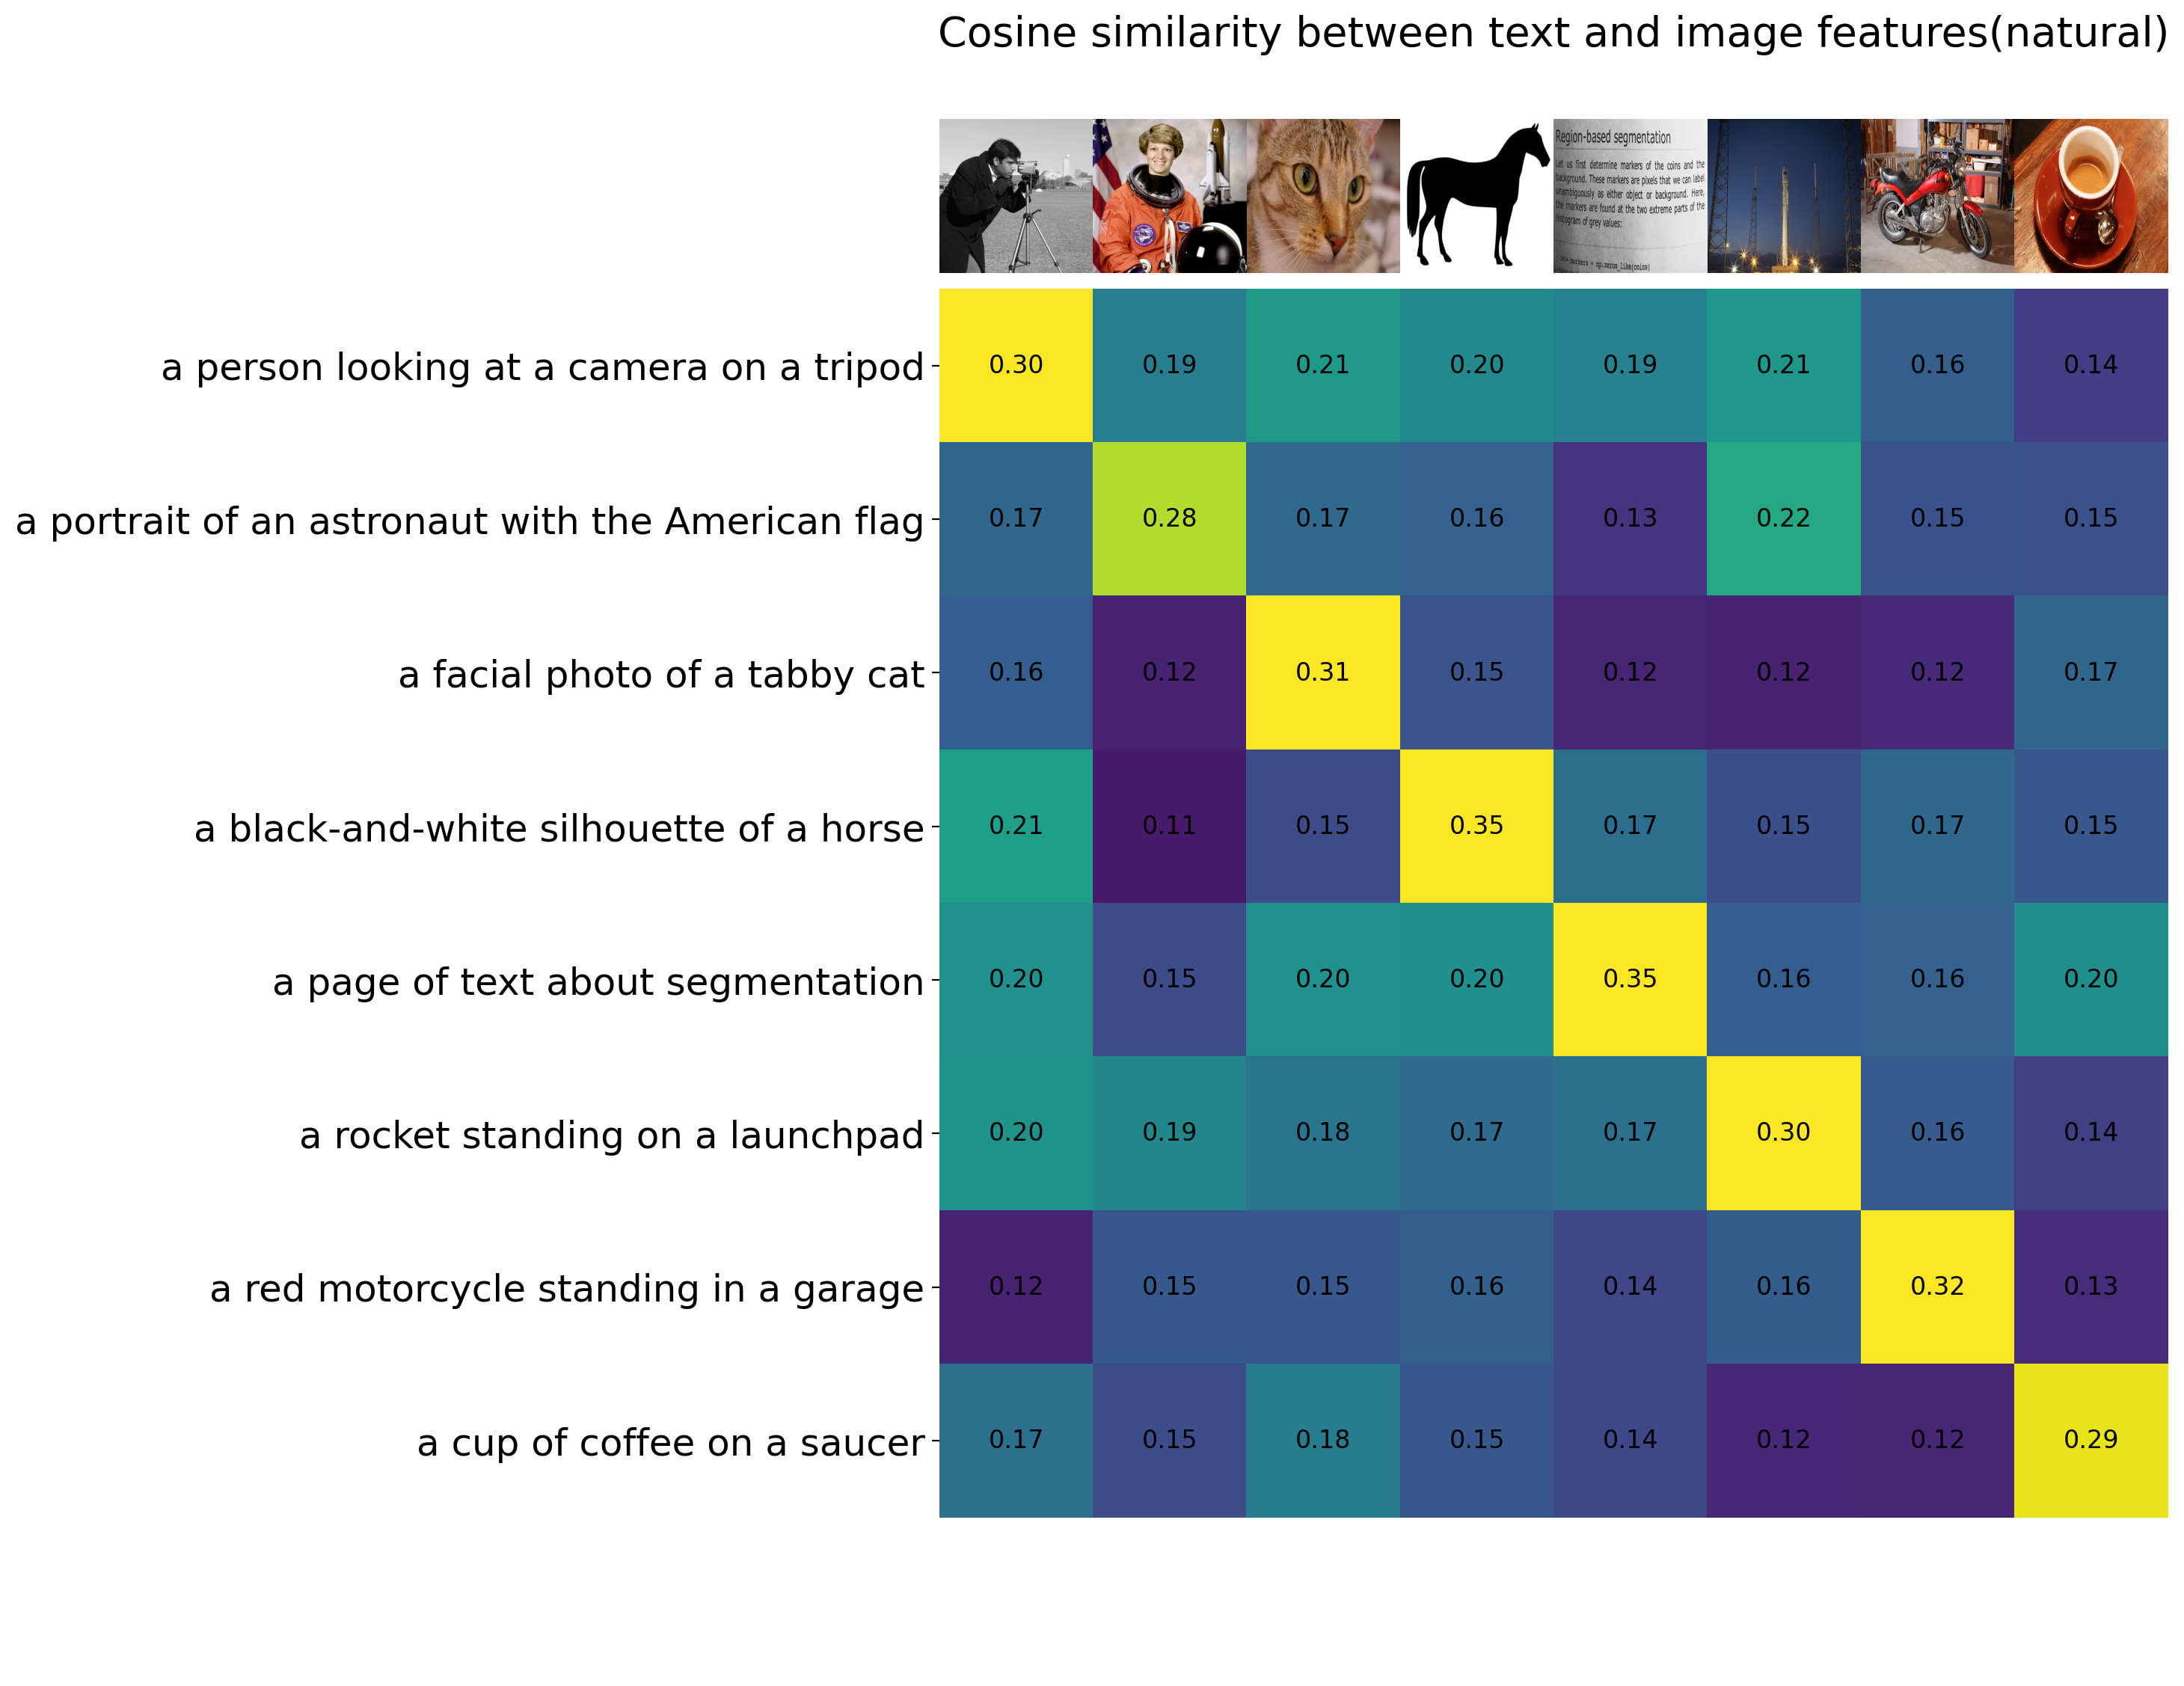

In [ ]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

count = len(descriptions)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features(natural)", size=20)

## Performance of CLIP in medical domain

Text(0.5, 1.0, 'Cosine similarity between text and image features(medical)')

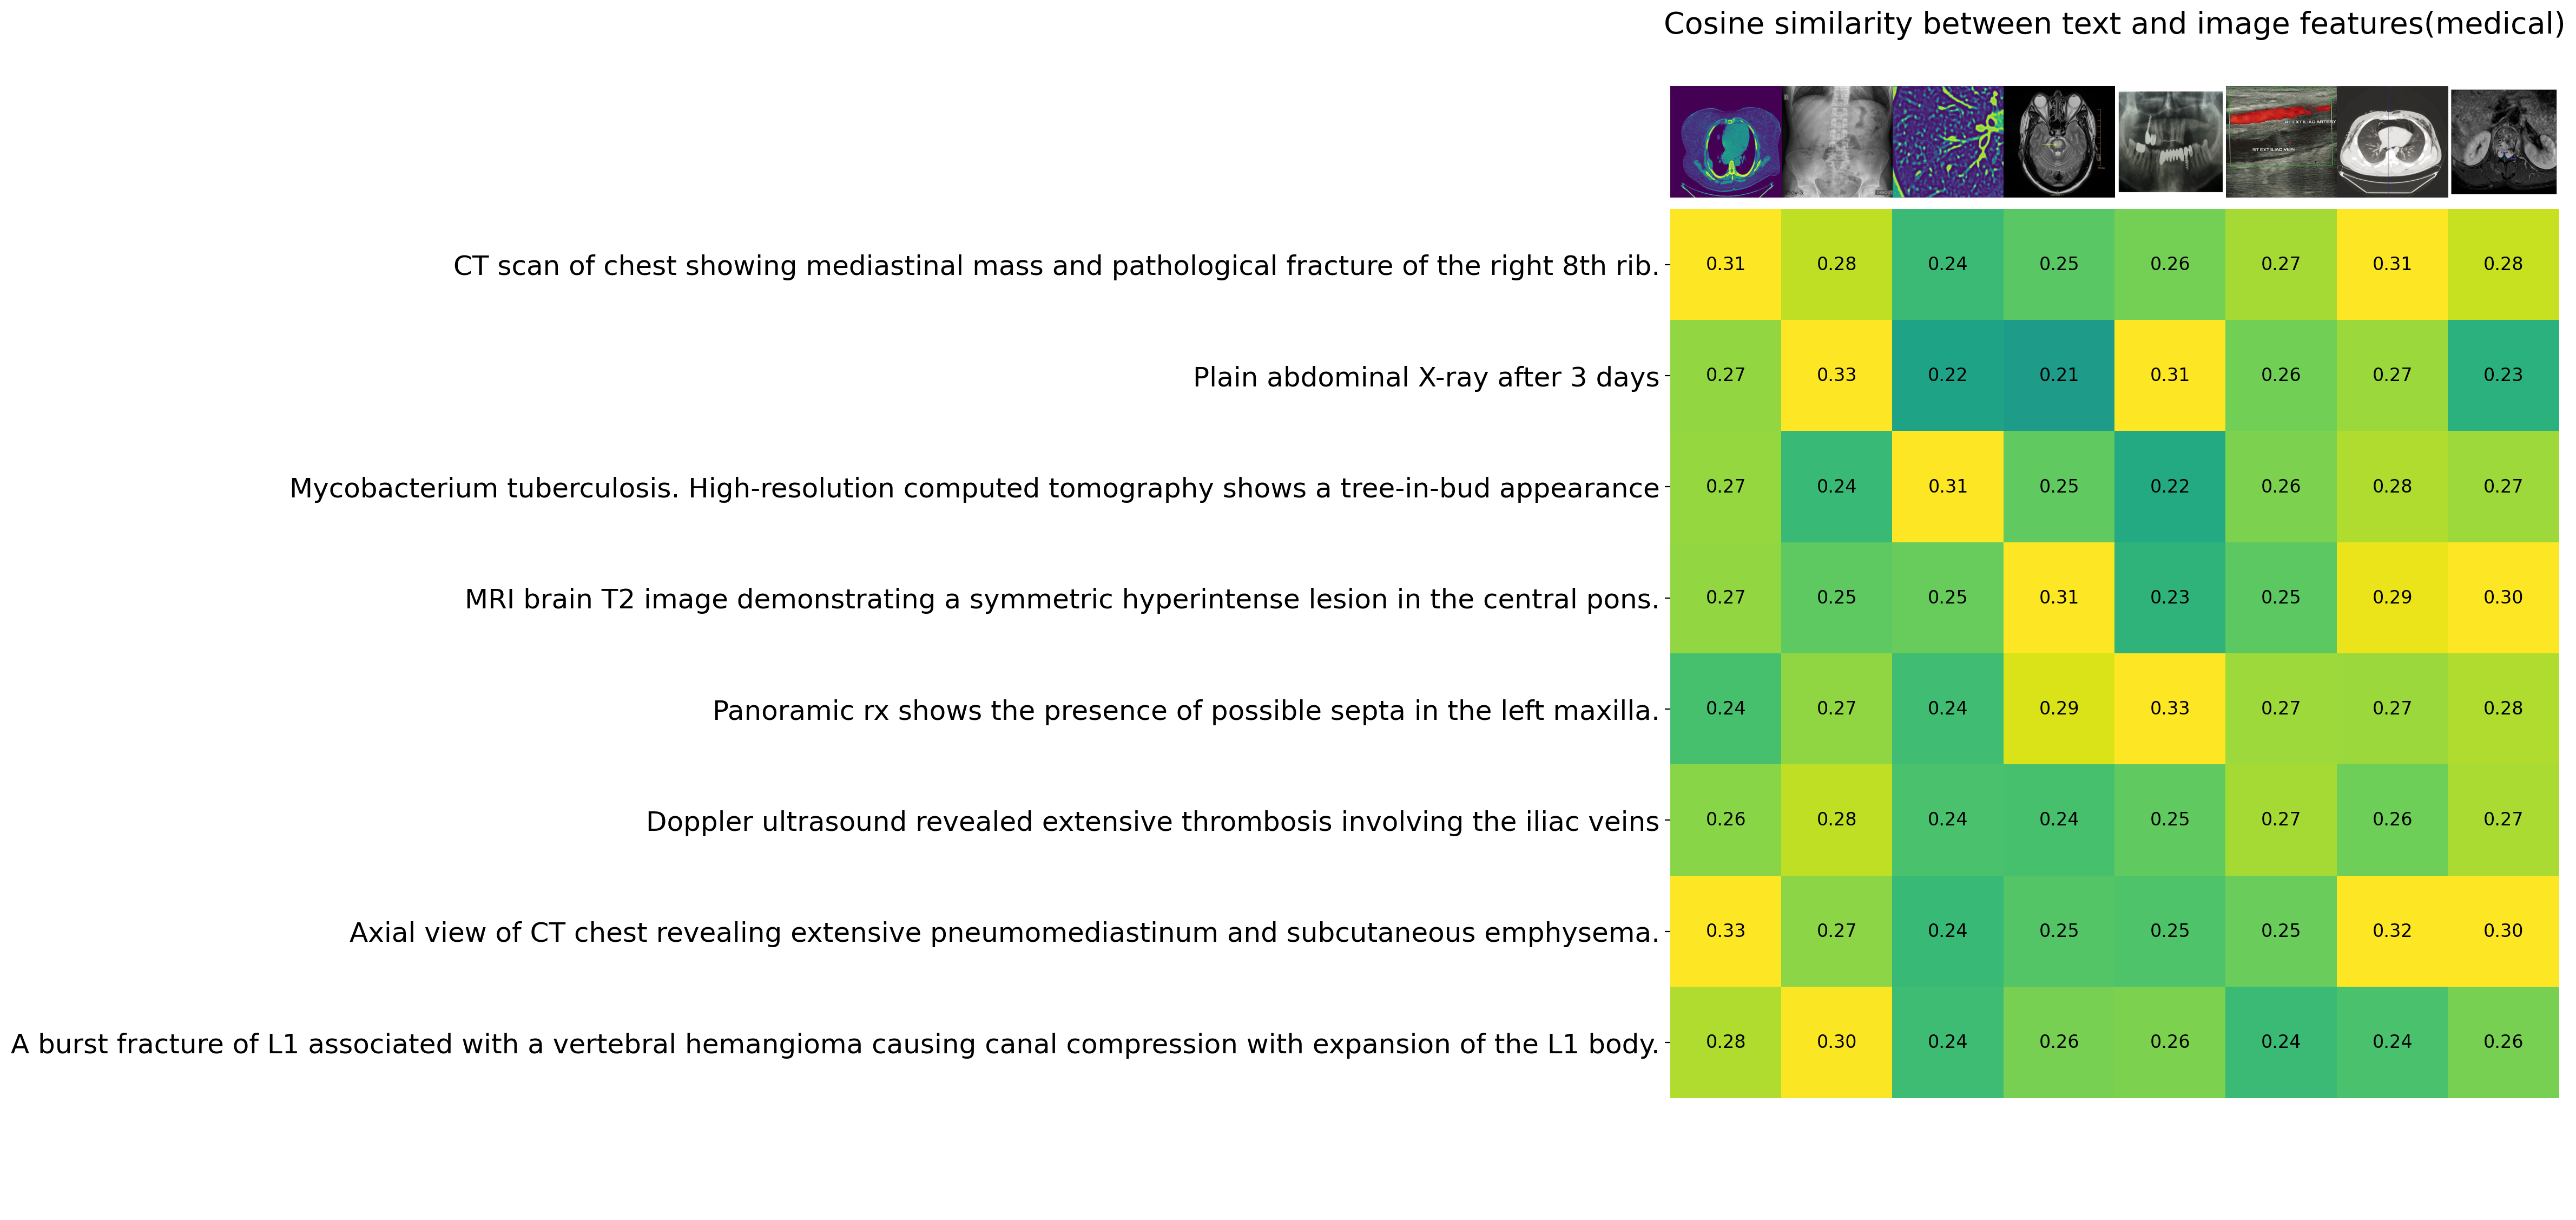

In [ ]:
original_images = []
images = []
texts = []
for filename in list(med_descriptions_2.keys()):
    image = Image.open(os.path.join("/content/drive/MyDrive/Aide_a_la_decision_TP2/data/pretrain_data/roco/train/radiology/images", filename+'.jpg'))
    original_images.append(image)
    images.append(preprocess(image))
    texts.append(med_descriptions_2[filename])
image_input = torch.tensor(np.stack(images)).cuda()
text_tokens = clip.tokenize(["This is " + desc for desc in texts]).cuda()
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

count = len(descriptions)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)
for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features(medical)", size=20)


# Zero-Shot Image Classification

You can classify images using the cosine similarity (times 100) as the logits to the softmax operation.

In [ ]:
from torchvision.datasets import CIFAR100, Caltech101
cifar100 = CIFAR100(os.path.expanduser("~/.cache"), transform=preprocess, download=True)
caltech101 = Caltech101(os.path.expanduser("~/.cache"), transform=preprocess, download=True)

Files already downloaded and verified


131740031it [00:03, 38492340.41it/s]


Extracting /root/.cache/caltech101/101_ObjectCategories.tar.gz to /root/.cache/caltech101


14028800it [00:00, 40708844.23it/s]


Extracting /root/.cache/caltech101/Annotations.tar to /root/.cache/caltech101


In [ ]:
caltech101_root = caltech101.root

# The specific subdirectory for Caltech101
subdir = '101_ObjectCategories'

# Constructing the path to the images
image_dir = os.path.join(caltech101_root, subdir)

# Listing the directories (class names) in the root directory
class_names = [d for d in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, d))]

caltech101.classes = class_names

In [ ]:
caltech101.annotation_categories

['Faces_2',
 'Faces_3',
 'Leopards',
 'Motorbikes_16',
 'accordion',
 'Airplanes_Side_2',
 'anchor',
 'ant',
 'barrel',
 'bass',
 'beaver',
 'binocular',
 'bonsai',
 'brain',
 'brontosaurus',
 'buddha',
 'butterfly',
 'camera',
 'cannon',
 'car_side',
 'ceiling_fan',
 'cellphone',
 'chair',
 'chandelier',
 'cougar_body',
 'cougar_face',
 'crab',
 'crayfish',
 'crocodile',
 'crocodile_head',
 'cup',
 'dalmatian',
 'dollar_bill',
 'dolphin',
 'dragonfly',
 'electric_guitar',
 'elephant',
 'emu',
 'euphonium',
 'ewer',
 'ferry',
 'flamingo',
 'flamingo_head',
 'garfield',
 'gerenuk',
 'gramophone',
 'grand_piano',
 'hawksbill',
 'headphone',
 'hedgehog',
 'helicopter',
 'ibis',
 'inline_skate',
 'joshua_tree',
 'kangaroo',
 'ketch',
 'lamp',
 'laptop',
 'llama',
 'lobster',
 'lotus',
 'mandolin',
 'mayfly',
 'menorah',
 'metronome',
 'minaret',
 'nautilus',
 'octopus',
 'okapi',
 'pagoda',
 'panda',
 'pigeon',
 'pizza',
 'platypus',
 'pyramid',
 'revolver',
 'rhino',
 'rooster',
 'saxopho

In [ ]:
text_descriptions = [f"This is a photo of a {label}" for label in cifar100.classes]
text_tokens = clip.tokenize(text_descriptions).cuda()

In [ ]:
with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

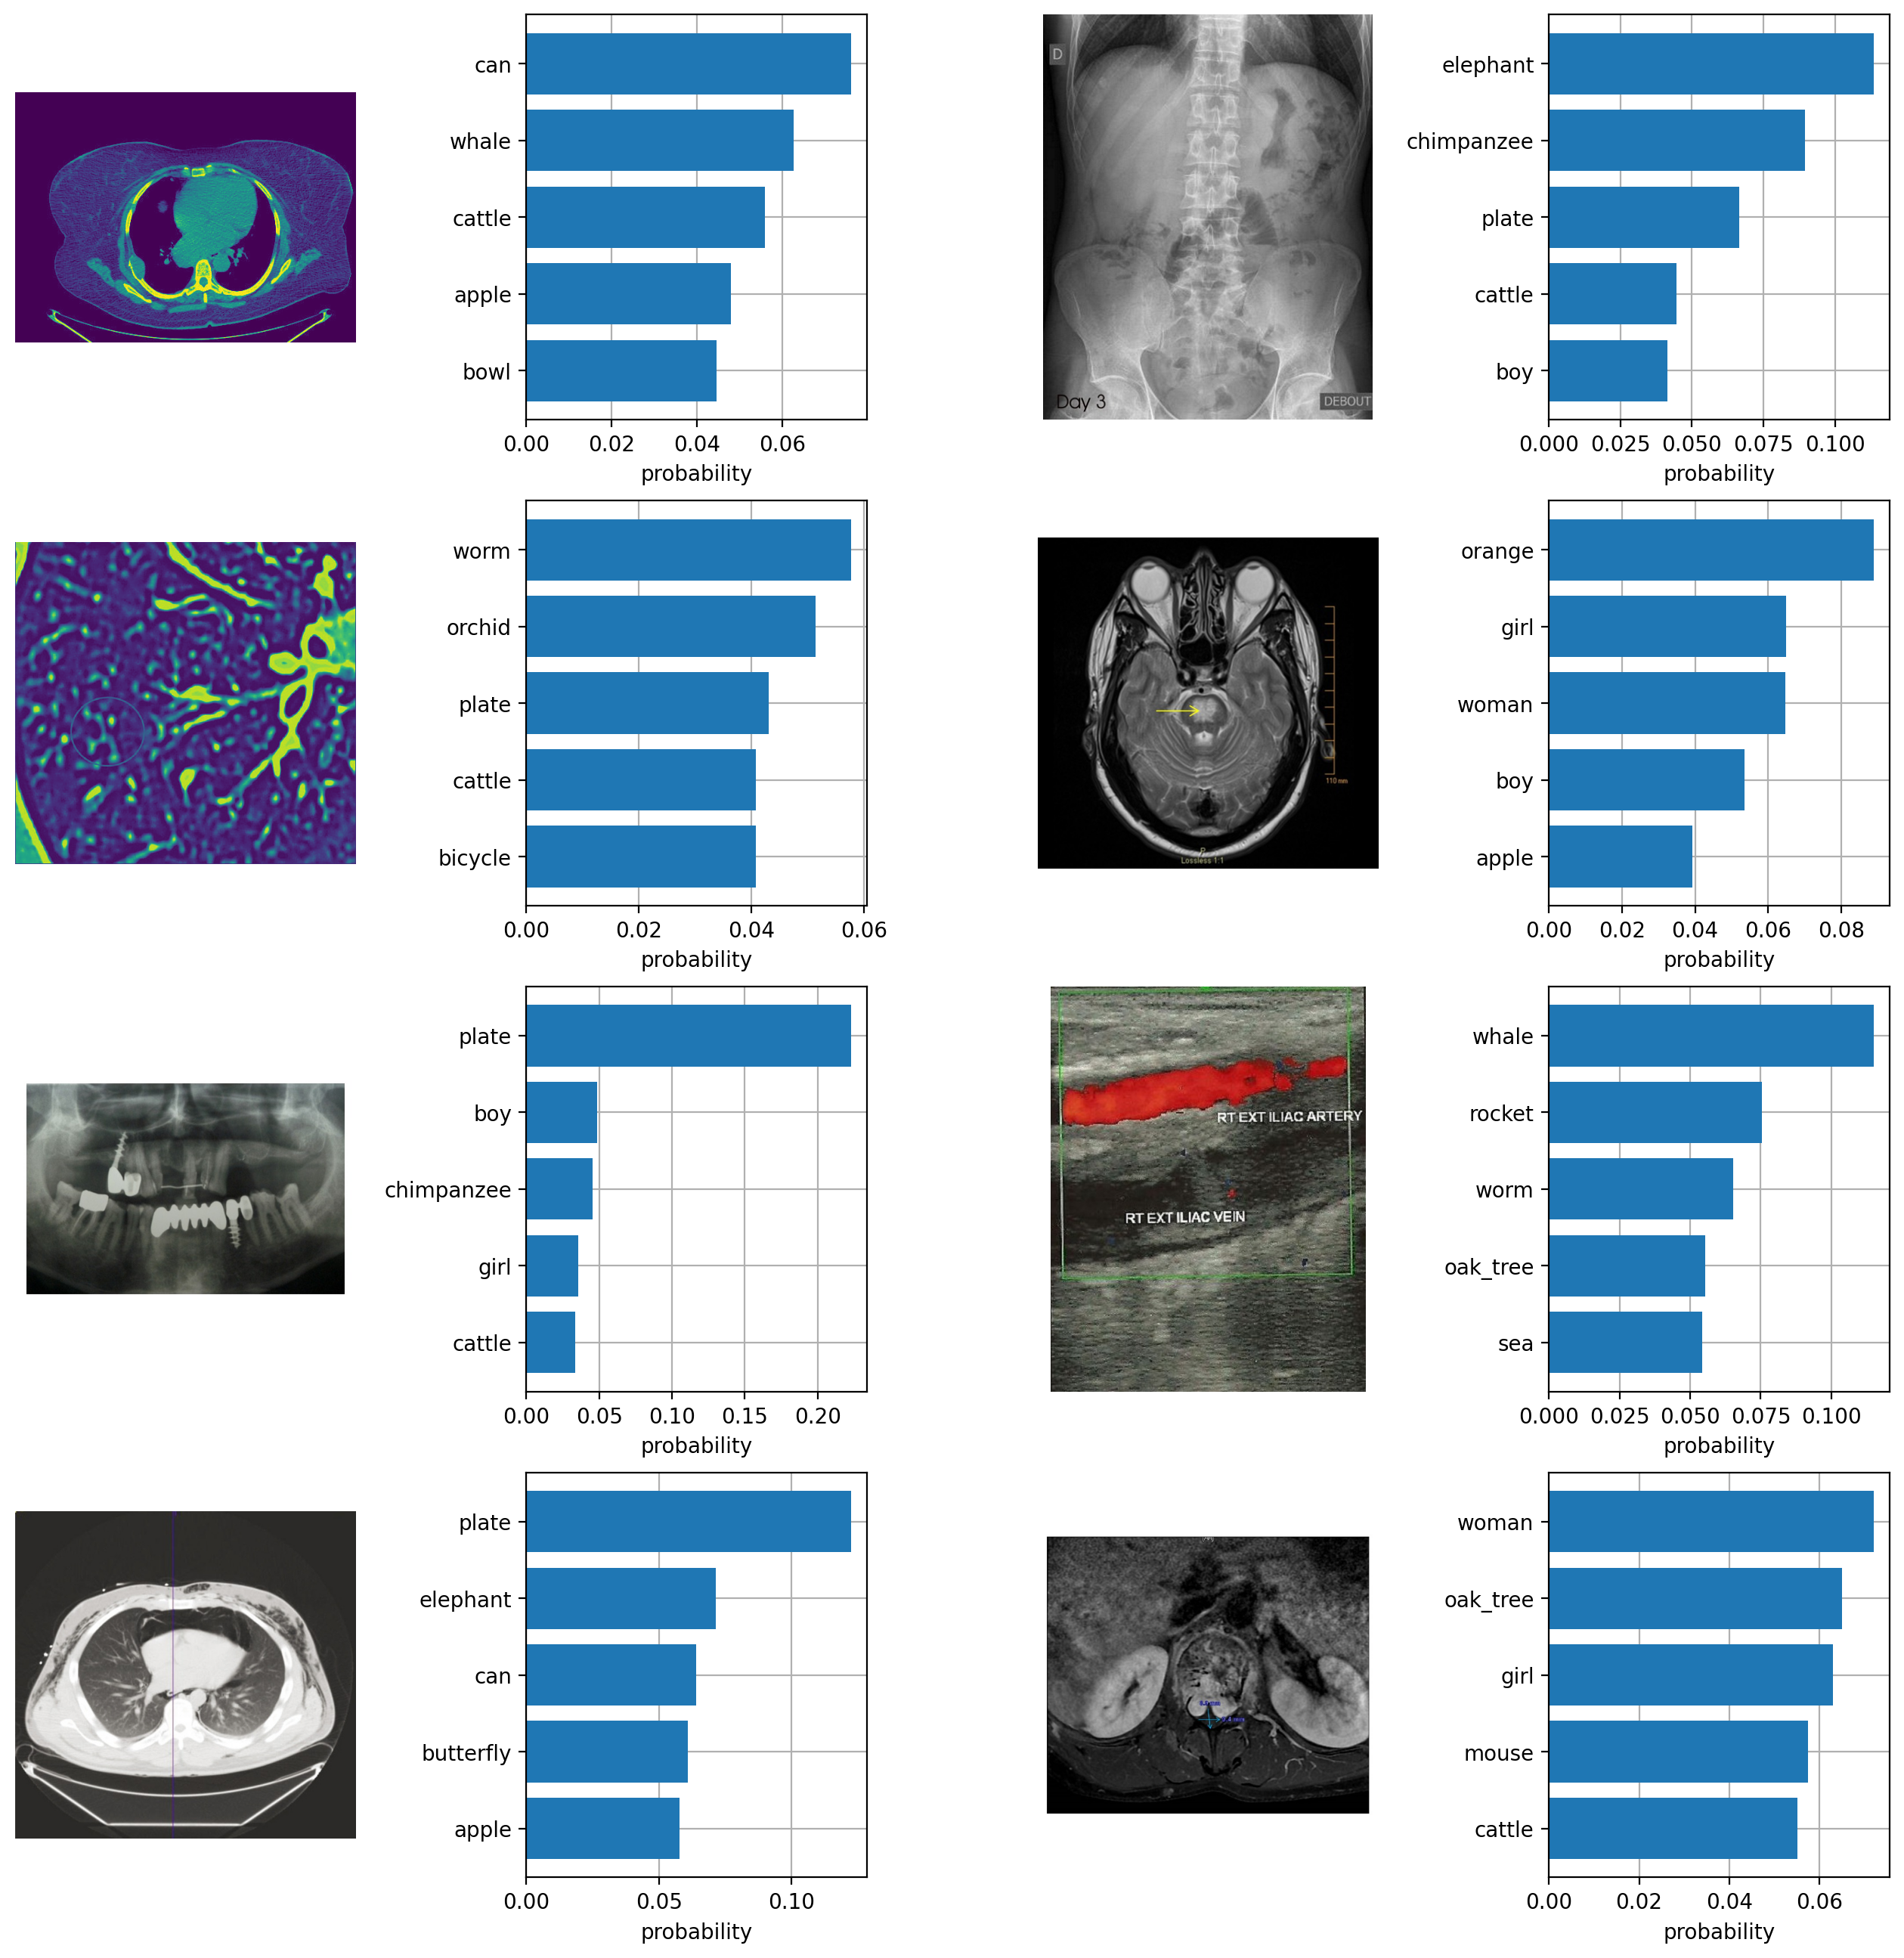

In [ ]:
plt.figure(figsize=(16, 16))

for i, image in enumerate(original_images):
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [cifar100.classes[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()

# Evaluation

In [ ]:
from torch.utils.data import DataLoader
from tqdm import tqdm

def evaluate_dataset(dataset, dataset_name):
    data_loader = DataLoader(dataset, batch_size=1000, shuffle=True)
    top1, top5 = 0, 0

    all_classes = []
    if dataset_name == 'Caltech101':
      all_classes = dataset.annotation_categories
    elif dataset_name == 'CIFAR100':
      all_classes = dataset.classes

    text_tokens = clip.tokenize([f"This is a photo of a {label}" for label in all_classes]).cuda()
    with torch.no_grad():
        text_features = model.encode_text(text_tokens).float()
        text_features /= text_features.norm(dim=-1, keepdim=True)

    for batch in tqdm(data_loader, f"Évaluation sur {dataset_name}"):
        images, labels = batch
        image_input = torch.tensor(np.stack(images)).cuda()

        with torch.no_grad():
            image_features = model.encode_image(image_input).float()
            image_features /= image_features.norm(dim=-1, keepdim=True)
            text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
            top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

            for i, true_label in enumerate(labels):
                if true_label.item() == top_labels[i, 0].item():
                    top1 += 1
                if true_label.item() in top_labels[i]:
                    top5 += 1

    total_images = len(dataset)
    top1_accuracy = top1 / total_images
    top5_accuracy = top5 / total_images

    return top1_accuracy, top5_accuracy

top1_accuracy_cifar100, top5_accuracy_cifar100 = evaluate_dataset(cifar100, "CIFAR100")
top1_accuracy_caltech101, top5_accuracy_caltech101 = evaluate_dataset(caltech101, "Caltech101")

In [ ]:
import seaborn as sns
from tabulate import tabulate

accuracy_data = [
    ["CIFAR100", round(top1_accuracy_cifar100, 3), round(top5_accuracy_cifar100, 3)],
    ["Caltech101", round(top1_accuracy_caltech101, 3), round(top5_accuracy_caltech101, 3)]
]

# Creating the table
table = tabulate(accuracy_data, headers=["Dataset", "Top-1 Accuracy", "Top-5 Accuracy"], tablefmt="pretty")
print(table)

+------------+----------------+----------------+
|  Dataset   | Top-1 Accuracy | Top-5 Accuracy |
+------------+----------------+----------------+
|  CIFAR100  |     0.589      |     0.852      |
| Caltech101 |      0.86      |     0.994      |
+------------+----------------+----------------+


In [ ]:
list_of_models = {'RN50': [0.2358, 0.5178],
                  'RN101': [0.4586, 0.7494],
                  'RN50x4': [0.2868, 0.5391],
                  'RN50x16': [0.4744, 0.7393],
                  'RN50x64': [0.4874, 0.7396],
                  'ViT-B/32': [0.5885, 0.8524],
                  'ViT-B/16': [0.4514, 0.7270],
                  'ViT-L/14': [0.7043, 0.9073],
                  'ViT-L/14@336px': [0.6970, 0.9059]}

data_for_table = [(model, round(scores[0], 3), round(scores[1], 3)) for model, scores in list_of_models.items()]

table = tabulate(data_for_table, headers=['Model', 'Top1 Score', 'Top5 Score'], tablefmt='pretty')

sorted_data = sorted(data_for_table, key=lambda x: x[1], reverse=True)

sorted_data_with_position = [(index+1,) + model_data for index, model_data in enumerate(sorted_data)]

table_sorted = tabulate(sorted_data_with_position, headers=['Position', 'Model', 'Top1 Score', 'Top5 Score'], tablefmt='pretty')

print('Scores obtenues sur CIFAR100')
print(table)
print(table_sorted)

+----------------+------------+------------+
|     Model      | Top1 Score | Top5 Score |
+----------------+------------+------------+
|      RN50      |   0.236    |   0.518    |
|     RN101      |   0.459    |   0.749    |
|     RN50x4     |   0.287    |   0.539    |
|    RN50x16     |   0.474    |   0.739    |
|    RN50x64     |   0.487    |    0.74    |
|    ViT-B/32    |   0.589    |   0.852    |
|    ViT-B/16    |   0.451    |   0.727    |
|    ViT-L/14    |   0.704    |   0.907    |
| ViT-L/14@336px |   0.697    |   0.906    |
+----------------+------------+------------+
+----------+----------------+------------+------------+
| Position |     Model      | Top1 Score | Top5 Score |
+----------+----------------+------------+------------+
|    1     |    ViT-L/14    |   0.704    |   0.907    |
|    2     | ViT-L/14@336px |   0.697    |   0.906    |
|    3     |    ViT-B/32    |   0.589    |   0.852    |
|    4     |    RN50x64     |   0.487    |    0.74    |
|    5     |    RN50x16

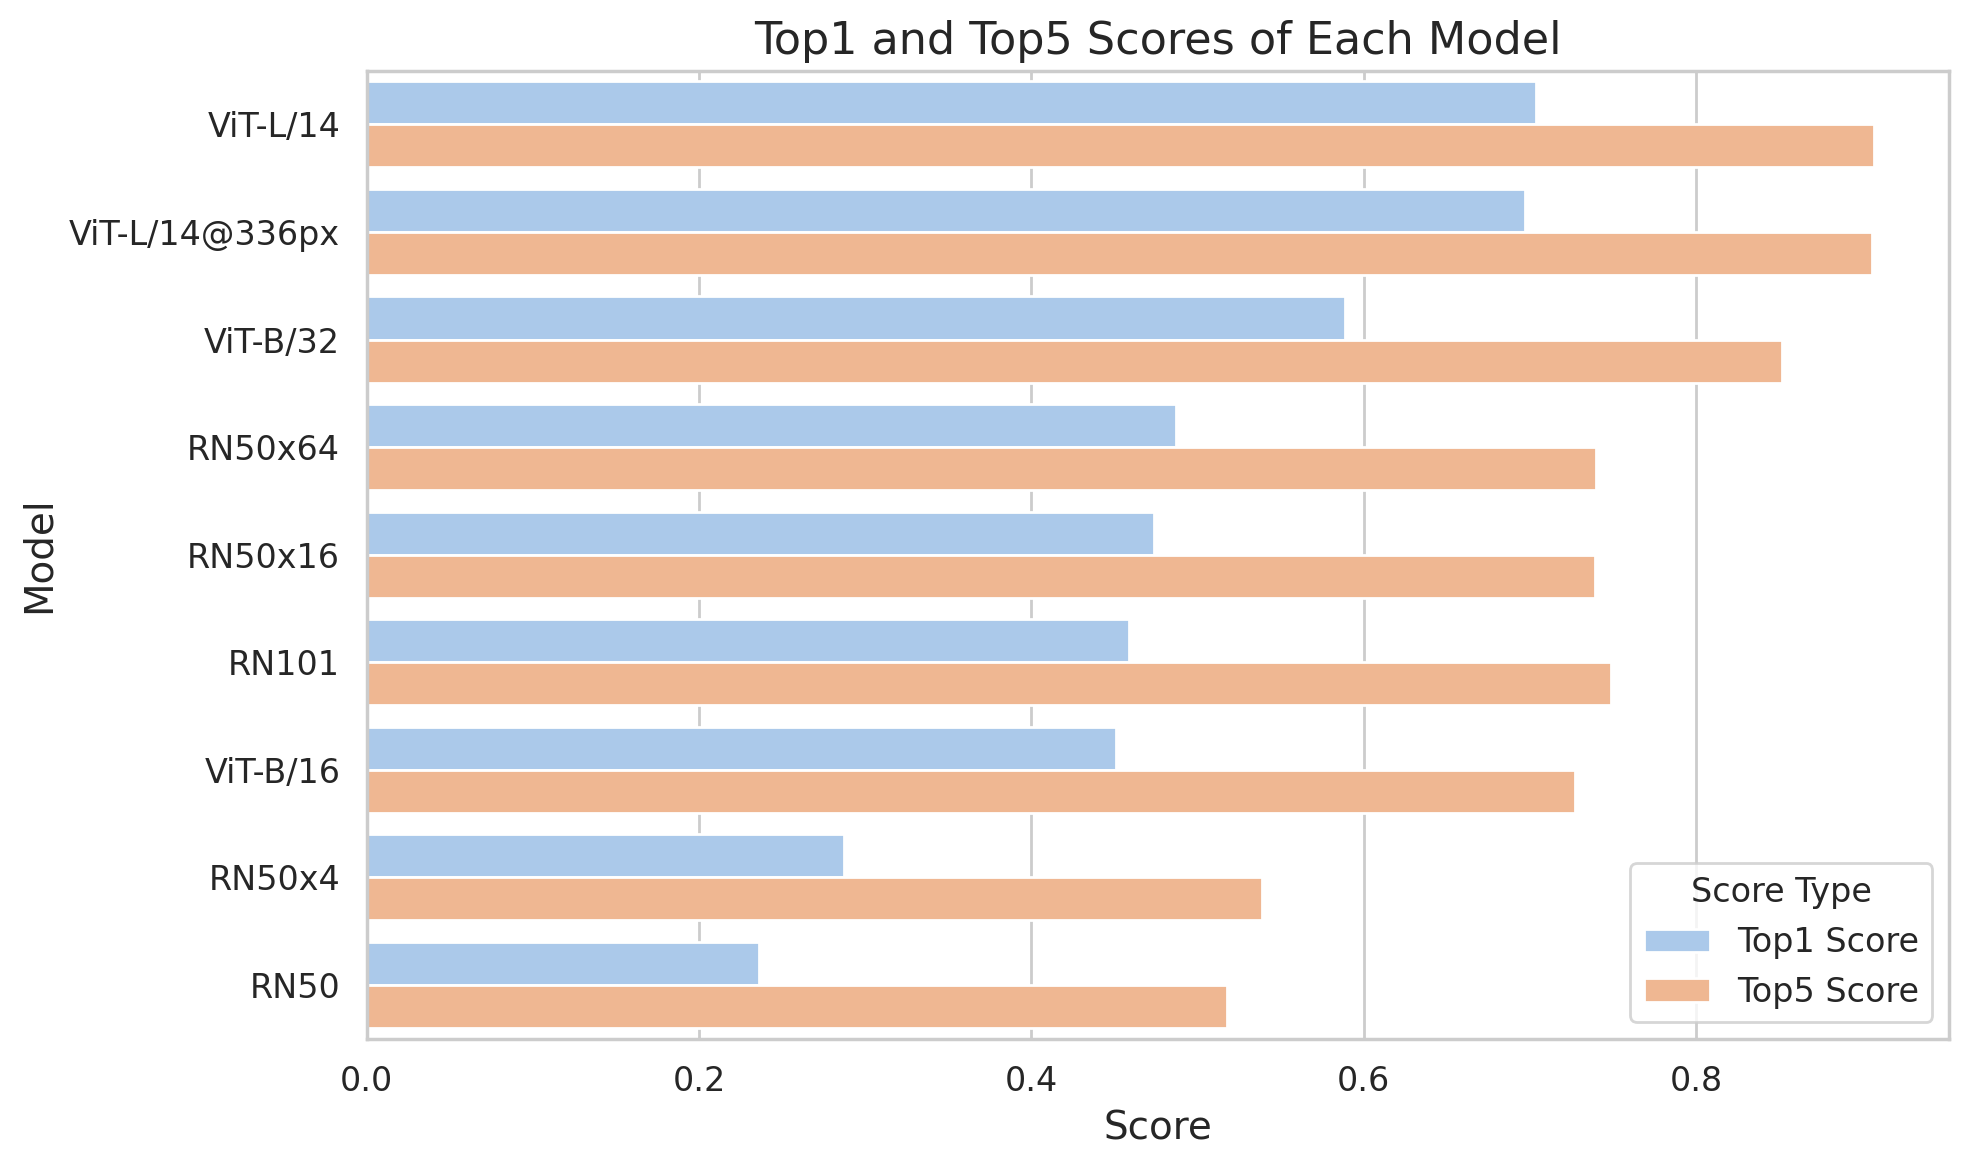

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame(sorted_data, columns=['Model', 'Top1 Score', 'Top5 Score'])

df_melted = df.melt('Model', var_name='Score Type', value_name='Score')
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.barplot(x='Score', y='Model', hue='Score Type', palette="pastel", data=df_melted)
plt.title('Top1 and Top5 Scores of Each Model', fontsize=16)
plt.xlabel('Score', fontsize=14)
plt.ylabel('Model', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Score Type', fontsize=12)
plt.tight_layout()
plt.show()

# Fine-tuning CLIP on ROCO



In [ ]:
# dataset location
csv_file ="/content/drive/MyDrive/Aide_a_la_decision_TP2/data/roco-list.csv"
root_dir = "/content/drive/MyDrive/Aide_a_la_decision_TP2/data/pretrain_data/roco/train/radiology/images"
val_csv_file = "/content/drive/MyDrive/Aide_a_la_decision_TP2/data/local-val-list.csv"
val_root_dir = "/content/drive/MyDrive/Aide_a_la_decision_TP2/data/pretrain_data/roco/val/radiology/images"

# train options
seed = 42
batch_size = 32
image_size = 224
start_epoch = 0
epochs = 1
visual_encoder = "clip@ViT-B/16"
learning_rate = 3e-6
model_path = "/content/drive/MyDrive/Aide_a_la_decision_TP2/checkpoints" # set to the directory containing `checkpoint_##.tar`


In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import torchvision
import datetime
import time
from tqdm import tqdm
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from torch.utils.data import Dataset
import random
import clip



class CLRDataset(Dataset):
    """Contrastive Learning Representations Dataset."""

    def __init__(self, csv_file, root_dir, transform=None, clip=False):
        self.clr_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.clip = clip

    def __len__(self):
        return len(self.clr_frame)

    def text_sampling(self, text):
        text = text.replace("\n", " ")
        text = text.split(".")
        if '' in text:
            text.remove('')
        text = random.choice(text)
        return text

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.clr_frame.iloc[idx, 0]
                                )
        if not os.path.exists(img_name):
            img_name=img_name.replace('train','val')
        image = Image.open(img_name)
        if not self.clip:
            image = image.convert('RGB')
        text = self.clr_frame.iloc[idx, 1]
        name = self.clr_frame.iloc[idx, 0]
        sample = {'image': image, 'text': text,'name':name}
        if self.clip:
            sample = self.transform(sample['image']), sample['text'],sample['name'] #self.text_sampling(sample['text'])
        elif self.transform:
            sample = self.transform(sample)

        return sample


def load_optimizer( model, lr=3e-6):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, epochs, eta_min=0, last_epoch=-1
    )
    return optimizer, scheduler


def train( train_loader, model, tokenizer, optimizer,truncation):
    loss_epoch = 0
    for step, (images, texts,name) in enumerate(train_loader):
        optimizer.zero_grad()
        x_v = images.to('cuda')
        x_u = tokenizer(list(texts), truncate=True).to('cuda')

        v,u=model(x_v,x_u)

        labels = torch.arange(batch_size, dtype=torch.long, device='cuda')

        loss_img = torch.nn.CrossEntropyLoss()
        loss_txt = torch.nn.CrossEntropyLoss()

        img_loss = loss_img(v,labels)
        text_loss = loss_txt(u,labels)

        loss = (img_loss + text_loss)/2

        loss.backward()
        optimizer.step()

        if step % 500 == 0:
            print(f"Step [{step}/{len(train_loader)}]\t Loss: {loss.item()}")

        loss_epoch += loss.item()
    return loss_epoch



def validate( val_loader, model, tokenizer, optimizer, truncation):

    with torch.no_grad():
        model.eval()
        loss_epoch = 0
        for step, (x_v, x_u) in enumerate(val_loader):
            x_v = x_v.to('cuda')
            x_u, _ = tokenizer(list(x_u), truncate=True).to('cuda')

            v,u=model(x_v,x_u)

            labels = torch.arange(batch_size, dtype=torch.long, device='cuda')

            loss_img = torch.nn.CrossEntropyLoss()
            loss_txt = torch.nn.CrossEntropyLoss()

            img_loss = loss_img(v,labels)
            text_loss = loss_txt(u,labels)

            loss = (img_loss + text_loss)/2
            loss_epoch += loss.item()

    model.train()
    return loss_epoch


def main(gpu):

    is_master=True

    # set GPU device
    torch.cuda.set_device(gpu)
    torch.manual_seed(seed)
    np.random.seed(seed)

    # initialize model
    print("Initializing model... ", end="", flush=True)
    model, preprocess = clip.load(visual_encoder.split("@")[-1], device='cuda', jit=False)
    model.float()
    tokenizer=clip.tokenize
    train_fonction = train
    validate_fonction = validate

    # optimizer
    optimizer, scheduler = load_optimizer(model, lr=float(learning_rate))

    # initialize dataloader
    transform = preprocess
    print('Image_Transform',transform)
    train_dataset = CLRDataset(csv_file=csv_file,
                               root_dir=root_dir,
                               transform=transform,
                               clip = True
                               )

    val_dataset = CLRDataset(csv_file=val_csv_file,
                             root_dir=val_root_dir,
                             transform=transform,
                             clip = True
                             )

    train_sampler = None
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=(train_sampler is None),
        drop_last=True,
        num_workers=8,
        sampler=train_sampler,
    )

    val_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=batch_size,
        drop_last=True,
        num_workers=8
    )

    print("[DONE]\n")
    print("STARTING TRAINING")
    print('Start Time =', datetime.datetime.now().strftime("%H:%M:%S"), '\n')

    t0 = time.time()
    global_step = 0
    current_epoch = 0
    best_val_loss = np.inf

    for epoch in range(0, epochs):
        if epoch<2:
            if train_sampler is not None:
                train_sampler.set_epoch(epoch)

            lr = optimizer.param_groups[0]["lr"]
            loss_epoch = train_fonction(train_loader, model, tokenizer, optimizer,True)

        if is_master:
            val_loss = validate_fonction( val_loader, model, tokenizer, optimizer, True)
            if val_loss < best_val_loss:
                torch.save(model.state_dict(), os.path.join(model_path, "best_checkpoint.pth"))
                best_val_loss = val_loss

            epoch_counter = epoch - 0
            elapsed = time.time() - t0
            epoch_time = elapsed/(epoch_counter+1)
            remaining = (epochs - (epoch_counter+1))*epoch_time
            remaining = str(datetime.timedelta(seconds=round(remaining)))
            elapsed = str(datetime.timedelta(seconds=round(elapsed)))
            print(f'Epoch {epoch_counter+1}/{epochs} [{elapsed}<{remaining}, {round(epoch_time, 2)}s/epoch] {round((epoch_counter+1)/epochs*100, 1)}% loss: {loss_epoch / len(train_loader)}\t val_loss: {val_loss / len(val_loader)} lr: {lr}')

            current_epoch += 1


if not os.path.exists(model_path):
    os.makedirs(model_path)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)
main(0)

Device: cuda:0
Initializing model... Image_Transform Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=warn)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7a6b5fb91e10>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)
[DONE]

STARTING TRAINING
Start Time = 10:27:37 



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Step [0/2043]	 Loss: 2.388209342956543


KeyboardInterrupt: ignored

## Performance of CLIP in medical domain(after fine-tuning on ROCO )

Text(0.5, 1.0, 'Cosine similarity between text and image features(medical)')

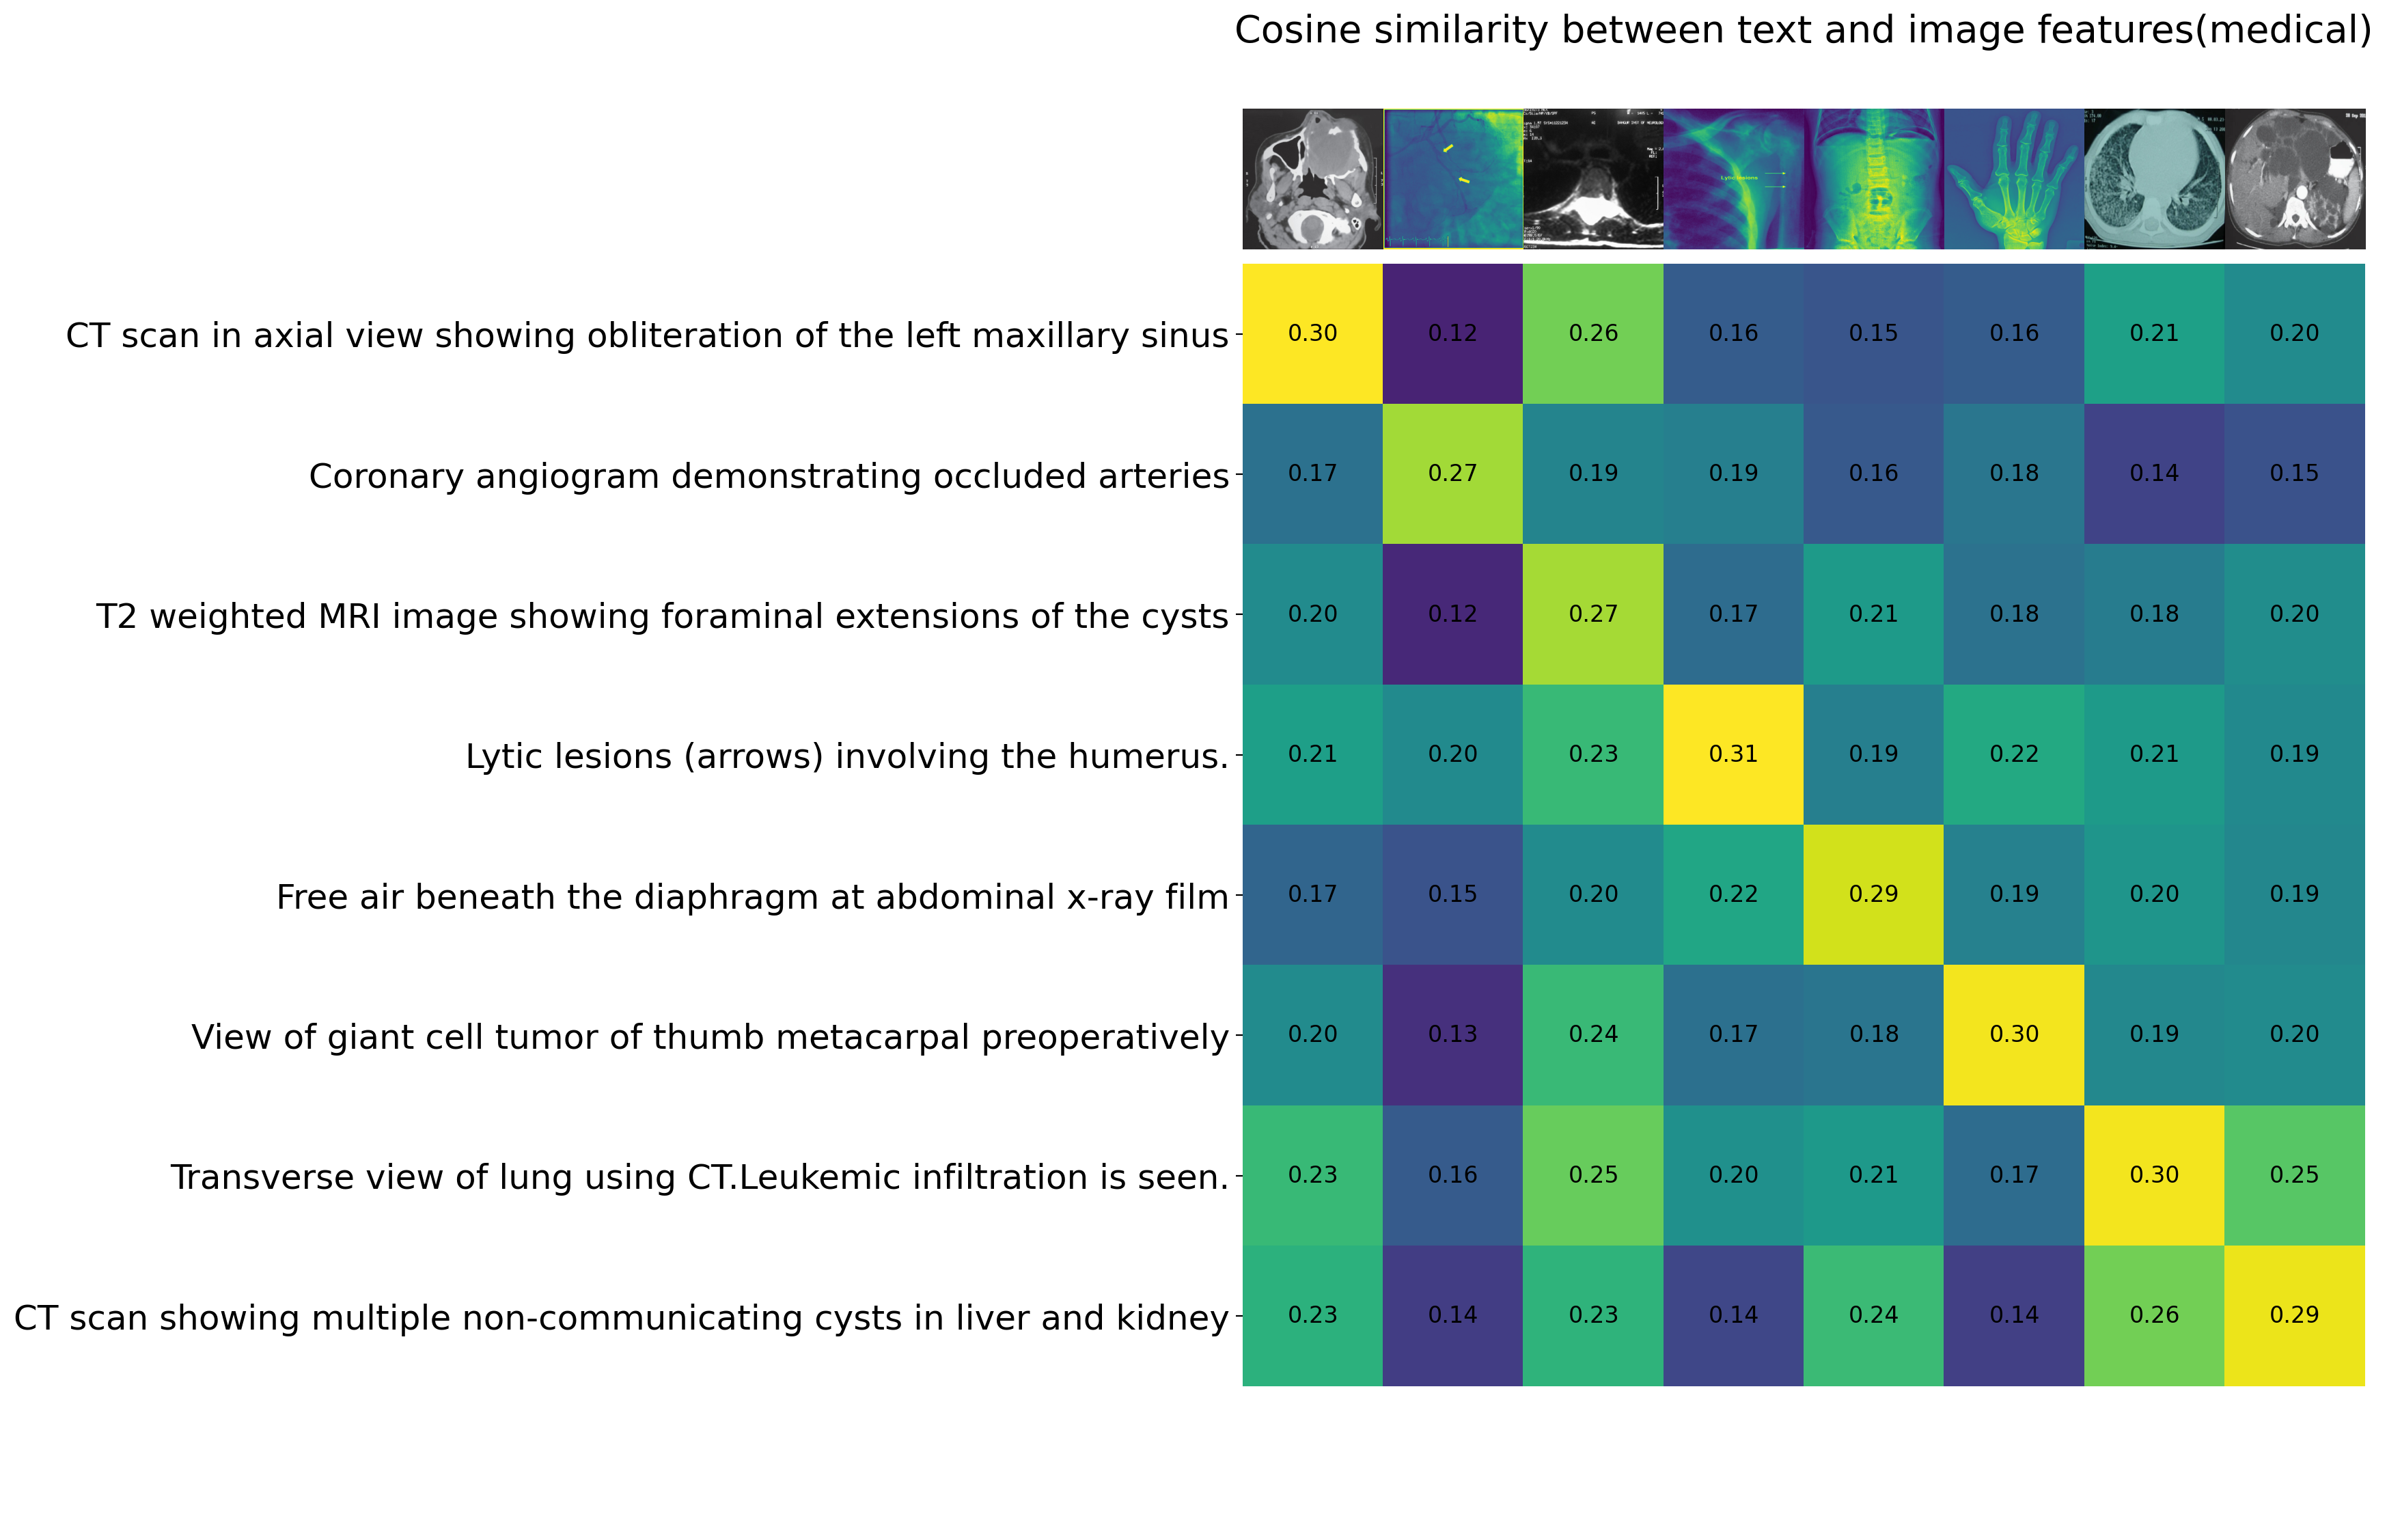

In [ ]:
#load checkpoint
model.load_state_dict(torch.load('/content/drive/MyDrive/Aide_a_la_decision_TP2/checkpoints/best_checkpoint.pth'))

#compute txt-img similarity again
original_images = []
images = []
texts = []
for filename in list(med_descriptions.keys()):
    image = Image.open(os.path.join(root_dir, filename+'.jpg'))
    original_images.append(image)
    images.append(preprocess(image))
    texts.append(med_descriptions[filename])
image_input = torch.tensor(np.stack(images)).cuda()
text_tokens = clip.tokenize(["This is " + desc for desc in texts]).cuda()
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

count = len(descriptions)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features(medical)", size=20)